In [1]:
# =================================================================================
# SECTION 1: PROJECT SCAFFOLDING & CONFIGURATION
# =================================================================================

# ---------------------------------------------------------------------------------
# 1.1: IMPORTS
# All necessary libraries for the project.
# ---------------------------------------------------------------------------------
%matplotlib inline 
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTModel, ViTConfig
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold # We might use this later for robustness
from collections import defaultdict
import copy

# Set a seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:

# ---------------------------------------------------------------------------------
# 1.2: CONFIGURATION CLASS
# This class holds all hyperparameters and settings in one place.
# ---------------------------------------------------------------------------------
class Config:
    # --- Data Paths and Domains ---
    # In your Config class
    DATA_DIR = r"D:\Salaar Masood\pacs-dataset\pacs_data"
    DOMAINS = ["art_painting", "cartoon", "photo", "sketch"]
    
    # --- Model & Architecture ---
    # In your Config class
    MODEL_NAME = "WinKawaks/vit-tiny-patch16-224"
    NUM_CLASSES = 7
    NUM_HEADS = 4
    DROPOUT_OPTIONS = [0.1, 0.2, 0.3, 0.4, 0.5,0.7]
    
    # --- Training Hyperparameters ---
    BATCH_SIZE = 128
    NUM_EPOCHS = 10
    LEARNING_RATE = 1e-4  # A good starting point for fine-tuning transformers
    OPTIMIZER = "AdamW"   # AdamW is generally preferred for transformers
    
    # --- Hardware & Reproducibility ---
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    SEED = 42

# Instantiate the config
config = Config()

# Print out the configuration to verify
print("--- Project Configuration ---")
for key, value in config.__class__.__dict__.items():
    if not key.startswith('__'):
        print(f"{key}: {value}")
print("---------------------------")
print(f"Device: {config.DEVICE}")

# ---------------------------------------------------------------------------------
# 1.3: RESULTS TRACKER
# A list to store the final results from each LODO experiment run.
# This will be converted to a DataFrame at the end for analysis.
# ---------------------------------------------------------------------------------
experiment_results = []

print("\nProject scaffolding is complete. Ready for Section 2: Data Loading.")

--- Project Configuration ---
DATA_DIR: D:\Salaar Masood\pacs-dataset\pacs_data
DOMAINS: ['art_painting', 'cartoon', 'photo', 'sketch']
MODEL_NAME: WinKawaks/vit-tiny-patch16-224
NUM_CLASSES: 7
NUM_HEADS: 4
DROPOUT_OPTIONS: [0.1, 0.2, 0.3, 0.4, 0.5, 0.7]
BATCH_SIZE: 128
NUM_EPOCHS: 10
LEARNING_RATE: 0.0001
OPTIMIZER: AdamW
DEVICE: cuda
SEED: 42
---------------------------
Device: cuda

Project scaffolding is complete. Ready for Section 2: Data Loading.


In [3]:
# =================================================================================
# SECTION 2: DATA LOADING & PREPROCESSING
# =================================================================================

# ---------------------------------------------------------------------------------
# 2.1: IMAGE TRANSFORMATIONS
# Define the transformations for training (with augmentation) and validation/testing.
# ---------------------------------------------------------------------------------

# The ViT model was pre-trained on images of size 224x224
IMG_SIZE = 224

# The normalization values are standard for many pre-trained models
# but it's good practice to use the ones specified by the model's authors if available.
# For ViT, a simple (0.5, 0.5, 0.5) normalization is common.
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(), # A simple data augmentation technique
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
}


In [4]:
# ---------------------------------------------------------------------------------
# 2.2: CUSTOM PACS DATASET CLASS
# This class will read the images and labels from our specific folder structure.
# ---------------------------------------------------------------------------------
class PACSDataset(Dataset):
    def __init__(self, root_dir, domains, transform=None):
        """
        Args:
            root_dir (string): Directory with all the domain folders.
            domains (list of string): List of domains to include in this dataset.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.domains = domains
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        # Discover all classes (dog, elephant, etc.) and map them to integers
        self.classes = sorted(os.listdir(os.path.join(root_dir, domains[0])))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        # Load image paths and labels from the specified domains
        for domain in self.domains:
            domain_path = os.path.join(self.root_dir, domain)
            for class_name in self.classes:
                class_path = os.path.join(domain_path, class_name)
                for img_name in os.listdir(class_path):
                    self.image_paths.append(os.path.join(class_path, img_name))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [5]:
# =================================================================================
# SECTION 2.3: DATALOADER HELPER FUNCTION (NEW 80/20 SPLIT VERSION)
# =================================================================================
# Replace the old get_dataloaders function in Section 2 of BOTH notebooks with this.

from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

def get_dataloaders(root_dir, target_domain, all_domains, batch_size, seed):
    """
    Creates dataloaders for a LODO split using an 80/20 split on the source domains.
    """
    source_domains = [d for d in all_domains if d != target_domain]
    
    print(f"--- Creating DataLoaders (80/20 Split Strategy) ---")
    print(f"Target (Test) Domain: {target_domain}")
    print(f"Source Domains for Train/Val: {source_domains}")
    
    # 1. Create a single, large dataset by combining all source domains
    source_dataset = PACSDataset(
        root_dir=root_dir, 
        domains=source_domains, 
        transform=data_transforms['train'] # Use training transforms for the whole source
    )
    
    # We need to perform a stratified split to ensure the train and val sets
    # have a similar distribution of classes.
    indices = list(range(len(source_dataset)))
    labels = source_dataset.labels
    
    # Use sklearn's train_test_split to get indices for an 80% train / 20% val split
    train_idx, val_idx = train_test_split(
        indices, 
        test_size=0.2, 
        stratify=labels, 
        random_state=seed
    )
    
    # 2. Create the training and validation subsets
    train_subset = Subset(source_dataset, train_idx)
    val_subset = Subset(source_dataset, val_idx)
    
    # Important: The validation subset should not use training augmentations (like RandomFlip).
    # We create a new dataset object for validation with the correct transforms.
    # This is a cleaner way to handle transforms for subsets.
    val_dataset_clean = PACSDataset(root_dir=root_dir, domains=source_domains, transform=data_transforms['val'])
    val_subset_final = Subset(val_dataset_clean, val_idx)
    
    # 3. Create the test dataset from the full target domain
    test_dataset = PACSDataset(
        root_dir=root_dir, 
        domains=[target_domain], 
        transform=data_transforms['val']
    )

    # 4. Create the DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_subset_final, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    print(f"Source data size: {len(source_dataset)}")
    print(f"  -> Training on: {len(train_subset)} images (80%)")
    print(f"  -> Validating on: {len(val_subset_final)} images (20%)")
    print(f"Testing on full '{target_domain}' domain: {len(test_dataset)} images")
    print("----------------------------------------------------")
    
    return train_loader, val_loader, test_loader

In [6]:
# =================================================================================
# SECTION 3: THE MODEL ARCHITECTURE
# =================================================================================

# ---------------------------------------------------------------------------------
# 3.1: CUSTOM ViT MODEL WITH EVOLUTIONARY HEADS
# We define a class that wraps the ViT backbone and adds our 4 competing heads.
# ---------------------------------------------------------------------------------

class EvolutionaryViT(nn.Module):
    def __init__(self, model_name, num_classes, dropout_rates: list):
        """
        Args:
            model_name (string): The name of the pre-trained ViT model from Hugging Face.
            num_classes (int): The number of output classes.
            num_heads (int): The number of parallel classification heads.
            dropout_rate (float): The dropout probability.
        """
        super(EvolutionaryViT, self).__init__()
        
        # 1. Load the pre-trained ViT backbone
        # We use ViTModel, which gives us the feature extractor without the final classification layer.
        self.vit_backbone = ViTModel.from_pretrained(model_name)
        
        # Get the hidden size (feature dimension) from the model's config
        hidden_dim = self.vit_backbone.config.hidden_size
        
        # 2. Create the list of competing heads
        # We use nn.ModuleList, which is the proper way to hold a list of PyTorch modules.
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Dropout(p=rate), # Use the specific rate for this head
                nn.Linear(hidden_dim, num_classes)
            ) for rate in dropout_rates
        ])

    def update_dropout_rates(self, new_rates: list):
        """
        Updates the dropout probability for each head.
        This allows us to change the rates between epochs without re-creating the model.
        """
        for i, head in enumerate(self.heads):
            # nn.Sequential has layers indexed. 0 is Dropout, 1 is Linear.
            head[0].p = new_rates[i]
        
    def forward(self, images):
        """
        Defines the forward pass of the model.
        """
        # 1. Get features from the backbone
        # The output is a dictionary-like object. We want the 'last_hidden_state'.
        outputs = self.vit_backbone(pixel_values=images)
        
        # For ViT, the feature representation for the entire image is the output
        # corresponding to the special [CLS] token, which is the first one.
        # Shape: (batch_size, sequence_length, hidden_dim) -> (batch_size, hidden_dim)
        feature_vector_z = outputs.last_hidden_state[:, 0, :]
        
        # 2. Pass the feature vector through all heads
        head_outputs = {}
        for i, head in enumerate(self.heads):
            head_outputs[f'head_{i+1}'] = head(feature_vector_z)
            
        return head_outputs

# --- Let's test it to make sure it works ---
print("\nModel architecture seems correct. Ready for Section 4: Training and Evaluation Logic.")


Model architecture seems correct. Ready for Section 4: Training and Evaluation Logic.


In [7]:
# =================================================================================
# SECTION 4: TRAINING & EVALUATION LOGIC
# =================================================================================

# =================================================================================
# SECTION 4.1: TRAIN_ONE_EPOCH FUNCTION (FINAL "TRAIN ALL" STRATEGY)
# =================================================================================
# Replace your old train_one_epoch function with this new, correct version.

def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_winner_loss = 0.0
    head_correct_preds = defaultdict(int)
    total_samples = 0
    progress_bar = tqdm(train_loader, desc="Training Epoch", leave=False)

    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        # --- Step 1: Main Forward Pass ---
        # We get the feature vector z WITH the graph attached
        z = model.vit_backbone(pixel_values=images).last_hidden_state[:, 0, :]
        
        # --- Step 2: Create a Detached Copy of z ---
        # This z_detached has the same values but no gradient history linking it to the backbone.
        z_detached = z.detach()

        # --- Step 3: Calculate All Losses and Find the Winner ---
        head_outputs = {}
        all_losses = {}
        batch_accuracies = {}

        for i, head in enumerate(model.heads):
            head_name = f'head_{i+1}'
            
            # Use the "live" z for the winner's path, detached z for losers' path
            # We calculate both for now and decide which one to use for backprop later
            live_logits = head(z)
            detached_logits = head(z_detached)

            head_outputs[head_name] = live_logits # Store live logits for accuracy check
            
            # Store the two possible losses for each head
            all_losses[head_name] = {
                'live': criterion(live_logits, labels),
                'detached': criterion(detached_logits, labels)
            }

            # Find accuracy to determine the winner
            _, preds = torch.max(live_logits, 1)
            correct = torch.sum(preds == labels).item()
            batch_accuracies[head_name] = correct / labels.size(0)

        winner_head_name = max(batch_accuracies, key=batch_accuracies.get)

        # --- Step 4: Combine Losses for Backpropagation ---
        # Start with the winner's "live" loss, which will train the backbone.
        final_loss = all_losses[winner_head_name]['live']
        
        # Add the losers' "detached" losses, which will only train the heads.
        for head_name, loss_dict in all_losses.items():
            if head_name != winner_head_name:
                final_loss += loss_dict['detached']
        
        # --- Step 5: Single Backpropagation and Optimizer Step ---
        optimizer.zero_grad()
        final_loss.backward()
        optimizer.step()

        # --- Update logging stats ---
        total_winner_loss += all_losses[winner_head_name]['live'].item()
        for head_name, logits in head_outputs.items():
             _, preds = torch.max(logits, 1)
             head_correct_preds[head_name] += torch.sum(preds == labels).item()
        total_samples += labels.size(0)
    
    # --- End of Epoch ---
    final_head_accuracies = {name: (correct / total_samples) for name, correct in head_correct_preds.items()}
    return {
        "avg_winner_loss": total_winner_loss / len(train_loader),
        "head_accuracies": final_head_accuracies
    }

In [8]:
# =================================================================================
# SECTION 4: TRAINING & EVALUATION LOGIC (ADVANCED STRATEGY)
# =================================================================================


# ---------------------------------------------------------------------------------
# 4.2: EVALUATE FUNCTION
# (This function is correct and does not need to change)
# ---------------------------------------------------------------------------------
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct_preds = 0
    total_samples = 0
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Evaluating", leave=False)
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            total_samples += labels.size(0)
            head_outputs = model(images)
            all_logits = torch.stack(list(head_outputs.values()))
            ensembled_logits = torch.mean(all_logits, dim=0)
            loss = criterion(ensembled_logits, labels)
            total_loss += loss.item()
            _, preds = torch.max(ensembled_logits, 1)
            correct_preds += torch.sum(preds == labels).item()
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_preds / total_samples
    return {
        "avg_loss": avg_loss,
        "accuracy": accuracy
    }

In [ ]:
# =================================================================================
# SECTION 5: THE MAIN EXPERIMENT LOOP (ADVANCED STRATEGY)
# =================================================================================
# This version implements the "Winner-Stays, Losers-Re-roll" dropout strategy.
# The dropout rates are now dynamic and adapt based on epoch performance.
# ---------------------------------------------------------------------------------

# A fresh copy of the config to ensure we start clean
config = Config()
lodo_histories = {} # <--- ADD THIS LINE


# Loop over each domain to set it as the target domain once
for target_domain in config.DOMAINS:
    print(f"==============================================================")
    print(f"  STARTING LODO EXPERIMENT: Target Domain = {target_domain.upper()}")
    print(f"==============================================================")
    
    # --- 1. Setup for this specific LODO run ---
    # Get the specific data loaders for this train/test split
    train_loader, val_loader, test_loader = get_dataloaders(
        root_dir=config.DATA_DIR,
        target_domain=target_domain,
        all_domains=config.DOMAINS,
        batch_size=config.BATCH_SIZE, seed=config.SEED
    )
    
    # Initialize the first set of random dropout rates for the competing heads.
    # np.random.choice ensures we get unique rates if possible.
    current_dropout_rates = list(np.random.choice(
        config.DROPOUT_OPTIONS, 
        config.NUM_HEADS, 
        replace=False # Tries to pick unique rates
    ))
    
    # Initialize a fresh model with the starting dropout rates
    model = EvolutionaryViT(
        model_name=config.MODEL_NAME,
        num_classes=config.NUM_CLASSES,
        dropout_rates=current_dropout_rates # Pass the list of rates
    ).to(config.DEVICE)
    
    # Initialize a fresh optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    
    # --- 2. Training Loop for this LODO run ---
    best_val_accuracy = 0.0
    best_model_state = None

    history = {
        "train_loss": [],
        "val_loss": [],
        "val_accuracy": []
    }
    
    for epoch in range(config.NUM_EPOCHS):
        print(f"\n--- Epoch {epoch+1}/{config.NUM_EPOCHS} ---")
        print(f"Current Dropout Rates: { {f'head_{i+1}': rate for i, rate in enumerate(current_dropout_rates)} }")
        
        # Train for one epoch using the per-batch winner selection
        train_metrics = train_one_epoch(model, train_loader, optimizer, criterion, config.DEVICE)
        
        # Evaluate on the validation set to check progress and save the best model
        val_metrics = evaluate(model, val_loader, criterion, config.DEVICE)
        
        print(f"Epoch {epoch+1} Summary:")
        print(f"  Train Avg Winner Loss: {train_metrics['avg_winner_loss']:.4f}")
        print(f"  Validation Loss: {val_metrics['avg_loss']:.4f}")
        print(f"  Validation Accuracy: {val_metrics['accuracy']:.4f}")

        history["train_loss"].append(train_metrics['avg_winner_loss'])
        history["val_loss"].append(val_metrics['avg_loss'])
        history["val_accuracy"].append(val_metrics['accuracy'])
        
        # Check if this is the best model so far based on validation performance
        if val_metrics['accuracy'] > best_val_accuracy:
            print(f"  New best validation accuracy! Saving model state.")
            best_val_accuracy = val_metrics['accuracy']
            best_model_state = copy.deepcopy(model.state_dict())

        # --- Adaptive Dropout Logic for the NEXT epoch ---
        # Find the head that had the best OVERALL accuracy during this epoch
        epoch_winner_head_name = max(train_metrics['head_accuracies'], key=train_metrics['head_accuracies'].get)
        epoch_winner_index = int(epoch_winner_head_name.split('_')[-1]) - 1
        
        print(f"  Epoch Training Accuracies:")
        for name, acc in sorted(train_metrics['head_accuracies'].items()):
            marker = "<- WINNER" if name == epoch_winner_head_name else ""
            print(f"    {name}: {acc:.4f} {marker}")
        
        # Keep the winner's dropout rate for the next epoch
        winner_rate = current_dropout_rates[epoch_winner_index]
        
        # Generate a new set of random rates for all heads
        new_random_rates = list(np.random.choice(config.DROPOUT_OPTIONS, config.NUM_HEADS, replace=False))
        
        # "Exploitation": Overwrite the winner's slot with its successful rate
        new_random_rates[epoch_winner_index] = winner_rate
        
        # "Exploration": The other heads get new random rates
        current_dropout_rates = new_random_rates
        
        # Update the model in-place with the new dropout rates
        model.update_dropout_rates(current_dropout_rates)
            
    # --- 3. Final Evaluation for this LODO run ---
    print("\nTraining complete for this LODO split.")
    print("Loading best model state and evaluating on the TEST set...")
    
    # Load the best performing model based on validation accuracy
    model.load_state_dict(best_model_state)
    
    # Evaluate on the unseen target domain (the test set)
    test_metrics = evaluate(model, test_loader, criterion, config.DEVICE)
    
    print(f"\n--- RESULTS FOR TARGET DOMAIN: {target_domain.upper()} ---")
    print(f"  Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"--------------------------------------------------")
    
    lodo_histories[target_domain] = history
    # --- 4. Store the final results ---
    experiment_results.append({
        "target_domain": target_domain,
        "source_domains": [d for d in config.DOMAINS if d != target_domain],
        "test_accuracy": test_metrics['accuracy'],
        "best_val_accuracy": best_val_accuracy,
        "model_name": config.MODEL_NAME,
        "num_epochs": config.NUM_EPOCHS,
        "batch_size": config.BATCH_SIZE,
        "learning_rate": config.LEARNING_RATE
    })

print("\n\n==============================================================")
print("          ALL ADAPTIVE DROPOUT LODO EXPERIMENTS COMPLETE")
print("==============================================================")

  STARTING LODO EXPERIMENT: Target Domain = ART_PAINTING
--- Creating DataLoaders (80/20 Split Strategy) ---
Target (Test) Domain: art_painting
Source Domains for Train/Val: ['cartoon', 'photo', 'sketch']
Source data size: 7943
  -> Training on: 6354 images (80%)
  -> Validating on: 1589 images (20%)
Testing on full 'art_painting' domain: 2048 images
----------------------------------------------------


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/10 ---
Current Dropout Rates: {'head_1': 0.1, 'head_2': 0.2, 'head_3': 0.7, 'head_4': 0.3}


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1 Summary:
  Train Avg Winner Loss: 10.6392
  Validation Loss: 0.7696
  Validation Accuracy: 0.8181
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.1358 
    head_2: 0.6662 <- WINNER
    head_3: 0.1497 
    head_4: 0.2167 

--- Epoch 2/10 ---
Current Dropout Rates: {'head_1': 0.4, 'head_2': 0.2, 'head_3': 0.2, 'head_4': 0.3}


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2 Summary:
  Train Avg Winner Loss: 6.6487
  Validation Loss: 0.4198
  Validation Accuracy: 0.8836
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.2794 
    head_2: 0.8906 <- WINNER
    head_3: 0.2686 
    head_4: 0.4062 

--- Epoch 3/10 ---
Current Dropout Rates: {'head_1': 0.5, 'head_2': 0.2, 'head_3': 0.1, 'head_4': 0.4}


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3 Summary:
  Train Avg Winner Loss: 4.4185
  Validation Loss: 0.3443
  Validation Accuracy: 0.8823
  Epoch Training Accuracies:
    head_1: 0.4556 
    head_2: 0.9405 <- WINNER
    head_3: 0.5379 
    head_4: 0.5796 

--- Epoch 4/10 ---
Current Dropout Rates: {'head_1': 0.1, 'head_2': 0.2, 'head_3': 0.4, 'head_4': 0.2}


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4 Summary:
  Train Avg Winner Loss: 2.4561
  Validation Loss: 0.2924
  Validation Accuracy: 0.9062
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.7795 
    head_2: 0.9701 <- WINNER
    head_3: 0.6039 
    head_4: 0.8121 

--- Epoch 5/10 ---
Current Dropout Rates: {'head_1': 0.3, 'head_2': 0.2, 'head_3': 0.5, 'head_4': 0.1}


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5 Summary:
  Train Avg Winner Loss: 2.1120
  Validation Loss: 0.2496
  Validation Accuracy: 0.9144
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.7836 
    head_2: 0.9747 <- WINNER
    head_3: 0.6638 
    head_4: 0.8876 

--- Epoch 6/10 ---
Current Dropout Rates: {'head_1': 0.7, 'head_2': 0.2, 'head_3': 0.1, 'head_4': 0.4}


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6 Summary:
  Train Avg Winner Loss: 2.1283
  Validation Loss: 0.2365
  Validation Accuracy: 0.9182
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.6172 
    head_2: 0.9841 <- WINNER
    head_3: 0.8985 
    head_4: 0.8448 

--- Epoch 7/10 ---
Current Dropout Rates: {'head_1': 0.1, 'head_2': 0.2, 'head_3': 0.2, 'head_4': 0.5}


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7 Summary:
  Train Avg Winner Loss: 0.9429
  Validation Loss: 0.2247
  Validation Accuracy: 0.9220
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.9413 
    head_2: 0.9817 <- WINNER
    head_3: 0.9100 
    head_4: 0.8494 

--- Epoch 8/10 ---
Current Dropout Rates: {'head_1': 0.1, 'head_2': 0.2, 'head_3': 0.3, 'head_4': 0.5}


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8 Summary:
  Train Avg Winner Loss: 0.6698
  Validation Loss: 0.2360
  Validation Accuracy: 0.9239
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.9618 
    head_2: 0.9869 <- WINNER
    head_3: 0.9243 
    head_4: 0.9007 

--- Epoch 9/10 ---
Current Dropout Rates: {'head_1': 0.1, 'head_2': 0.2, 'head_3': 0.5, 'head_4': 0.4}


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9 Summary:
  Train Avg Winner Loss: 0.7206
  Validation Loss: 0.2422
  Validation Accuracy: 0.9182
  Epoch Training Accuracies:
    head_1: 0.9605 
    head_2: 0.9871 <- WINNER
    head_3: 0.8763 
    head_4: 0.9389 

--- Epoch 10/10 ---
Current Dropout Rates: {'head_1': 0.2, 'head_2': 0.2, 'head_3': 0.5, 'head_4': 0.7}


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10 Summary:
  Train Avg Winner Loss: 0.8975
  Validation Loss: 0.2526
  Validation Accuracy: 0.9232
  Epoch Training Accuracies:
    head_1: 0.9720 
    head_2: 0.9869 <- WINNER
    head_3: 0.9078 
    head_4: 0.8363 

Training complete for this LODO split.
Loading best model state and evaluating on the TEST set...


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


--- RESULTS FOR TARGET DOMAIN: ART_PAINTING ---
  Test Accuracy: 0.8101
--------------------------------------------------
  STARTING LODO EXPERIMENT: Target Domain = CARTOON
--- Creating DataLoaders (80/20 Split Strategy) ---
Target (Test) Domain: cartoon
Source Domains for Train/Val: ['art_painting', 'photo', 'sketch']
Source data size: 7647
  -> Training on: 6117 images (80%)
  -> Validating on: 1530 images (20%)
Testing on full 'cartoon' domain: 2344 images
----------------------------------------------------


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/10 ---
Current Dropout Rates: {'head_1': 0.7, 'head_2': 0.3, 'head_3': 0.5, 'head_4': 0.2}


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1 Summary:
  Train Avg Winner Loss: 10.3353
  Validation Loss: 0.7315
  Validation Accuracy: 0.7797
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.2679 
    head_2: 0.1491 
    head_3: 0.1723 
    head_4: 0.6459 <- WINNER

--- Epoch 2/10 ---
Current Dropout Rates: {'head_1': 0.4, 'head_2': 0.3, 'head_3': 0.5, 'head_4': 0.2}


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2 Summary:
  Train Avg Winner Loss: 6.5972
  Validation Loss: 0.4558
  Validation Accuracy: 0.8667
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.4854 
    head_2: 0.3052 
    head_3: 0.2740 
    head_4: 0.8877 <- WINNER

--- Epoch 3/10 ---
Current Dropout Rates: {'head_1': 0.5, 'head_2': 0.2, 'head_3': 0.1, 'head_4': 0.2}


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3 Summary:
  Train Avg Winner Loss: 3.8092
  Validation Loss: 0.3570
  Validation Accuracy: 0.8895
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.5820 
    head_2: 0.5723 
    head_3: 0.5792 
    head_4: 0.9371 <- WINNER

--- Epoch 4/10 ---
Current Dropout Rates: {'head_1': 0.5, 'head_2': 0.7, 'head_3': 0.2, 'head_4': 0.2}


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4 Summary:
  Train Avg Winner Loss: 3.6496
  Validation Loss: 0.3153
  Validation Accuracy: 0.8967
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.7167 
    head_2: 0.4893 
    head_3: 0.7409 
    head_4: 0.9689 <- WINNER

--- Epoch 5/10 ---
Current Dropout Rates: {'head_1': 0.1, 'head_2': 0.3, 'head_3': 0.7, 'head_4': 0.2}


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5 Summary:
  Train Avg Winner Loss: 2.4105
  Validation Loss: 0.2827
  Validation Accuracy: 0.8993
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.9071 
    head_2: 0.8172 
    head_3: 0.5617 
    head_4: 0.9727 <- WINNER

--- Epoch 6/10 ---
Current Dropout Rates: {'head_1': 0.5, 'head_2': 0.3, 'head_3': 0.1, 'head_4': 0.2}


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 6 Summary:
  Train Avg Winner Loss: 1.0367
  Validation Loss: 0.3241
  Validation Accuracy: 0.9013
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.8326 
    head_2: 0.8913 
    head_3: 0.9482 
    head_4: 0.9856 <- WINNER

--- Epoch 7/10 ---
Current Dropout Rates: {'head_1': 0.1, 'head_2': 0.3, 'head_3': 0.5, 'head_4': 0.2}


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 7 Summary:
  Train Avg Winner Loss: 0.7613
  Validation Loss: 0.3287
  Validation Accuracy: 0.9124
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.9635 
    head_2: 0.9179 
    head_3: 0.8836 
    head_4: 0.9822 <- WINNER

--- Epoch 8/10 ---
Current Dropout Rates: {'head_1': 0.1, 'head_2': 0.5, 'head_3': 0.3, 'head_4': 0.2}


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 8 Summary:
  Train Avg Winner Loss: 0.5292
  Validation Loss: 0.3244
  Validation Accuracy: 0.9170
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.9812 
    head_2: 0.8885 
    head_3: 0.9617 
    head_4: 0.9894 <- WINNER

--- Epoch 9/10 ---
Current Dropout Rates: {'head_1': 0.5, 'head_2': 0.3, 'head_3': 0.2, 'head_4': 0.2}


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 9 Summary:
  Train Avg Winner Loss: 0.2464
  Validation Loss: 0.3620
  Validation Accuracy: 0.9150
  Epoch Training Accuracies:
    head_1: 0.9748 
    head_2: 0.9738 
    head_3: 0.9823 
    head_4: 0.9926 <- WINNER

--- Epoch 10/10 ---
Current Dropout Rates: {'head_1': 0.4, 'head_2': 0.1, 'head_3': 0.3, 'head_4': 0.2}


Training Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 10 Summary:
  Train Avg Winner Loss: 0.2122
  Validation Loss: 0.4838
  Validation Accuracy: 0.9072
  Epoch Training Accuracies:
    head_1: 0.9801 
    head_2: 0.9825 
    head_3: 0.9792 
    head_4: 0.9890 <- WINNER

Training complete for this LODO split.
Loading best model state and evaluating on the TEST set...


Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]


--- RESULTS FOR TARGET DOMAIN: CARTOON ---
  Test Accuracy: 0.7675
--------------------------------------------------
  STARTING LODO EXPERIMENT: Target Domain = PHOTO
--- Creating DataLoaders (80/20 Split Strategy) ---
Target (Test) Domain: photo
Source Domains for Train/Val: ['art_painting', 'cartoon', 'sketch']
Source data size: 8321
  -> Training on: 6656 images (80%)
  -> Validating on: 1665 images (20%)
Testing on full 'photo' domain: 1670 images
----------------------------------------------------


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/10 ---
Current Dropout Rates: {'head_1': 0.2, 'head_2': 0.3, 'head_3': 0.4, 'head_4': 0.1}


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1 Summary:
  Train Avg Winner Loss: 8.9645
  Validation Loss: 1.0661
  Validation Accuracy: 0.6126
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.3120 
    head_2: 0.1979 
    head_3: 0.1303 
    head_4: 0.3748 <- WINNER

--- Epoch 2/10 ---
Current Dropout Rates: {'head_1': 0.2, 'head_2': 0.5, 'head_3': 0.3, 'head_4': 0.1}


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2 Summary:
  Train Avg Winner Loss: 6.7798
  Validation Loss: 0.5968
  Validation Accuracy: 0.8192
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.5346 
    head_2: 0.2822 
    head_3: 0.2162 
    head_4: 0.8035 <- WINNER

--- Epoch 3/10 ---
Current Dropout Rates: {'head_1': 0.2, 'head_2': 0.5, 'head_3': 0.7, 'head_4': 0.1}


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3 Summary:
  Train Avg Winner Loss: 5.8272
  Validation Loss: 0.3724
  Validation Accuracy: 0.8817
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.6807 
    head_2: 0.4058 
    head_3: 0.2982 
    head_4: 0.9052 <- WINNER

--- Epoch 4/10 ---
Current Dropout Rates: {'head_1': 0.5, 'head_2': 0.4, 'head_3': 0.2, 'head_4': 0.1}


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4 Summary:
  Train Avg Winner Loss: 3.1489
  Validation Loss: 0.2906
  Validation Accuracy: 0.9009
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.6696 
    head_2: 0.5930 
    head_3: 0.6555 
    head_4: 0.9470 <- WINNER

--- Epoch 5/10 ---
Current Dropout Rates: {'head_1': 0.7, 'head_2': 0.5, 'head_3': 0.3, 'head_4': 0.1}


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5 Summary:
  Train Avg Winner Loss: 2.8698
  Validation Loss: 0.2420
  Validation Accuracy: 0.9111
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.6540 
    head_2: 0.6782 
    head_3: 0.7523 
    head_4: 0.9681 <- WINNER

--- Epoch 6/10 ---
Current Dropout Rates: {'head_1': 0.5, 'head_2': 0.7, 'head_3': 0.3, 'head_4': 0.1}


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6 Summary:
  Train Avg Winner Loss: 2.1625
  Validation Loss: 0.2267
  Validation Accuracy: 0.9147
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.8484 
    head_2: 0.6544 
    head_3: 0.8373 
    head_4: 0.9839 <- WINNER

--- Epoch 7/10 ---
Current Dropout Rates: {'head_1': 0.4, 'head_2': 0.1, 'head_3': 0.2, 'head_4': 0.1}


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7 Summary:
  Train Avg Winner Loss: 0.7478
  Validation Loss: 0.1975
  Validation Accuracy: 0.9273
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.9100 
    head_2: 0.9414 
    head_3: 0.9142 
    head_4: 0.9880 <- WINNER

--- Epoch 8/10 ---
Current Dropout Rates: {'head_1': 0.2, 'head_2': 0.4, 'head_3': 0.5, 'head_4': 0.1}


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8 Summary:
  Train Avg Winner Loss: 0.9139
  Validation Loss: 0.2304
  Validation Accuracy: 0.9147
  Epoch Training Accuracies:
    head_1: 0.9494 
    head_2: 0.9038 
    head_3: 0.8498 
    head_4: 0.9890 <- WINNER

--- Epoch 9/10 ---
Current Dropout Rates: {'head_1': 0.5, 'head_2': 0.2, 'head_3': 0.4, 'head_4': 0.1}


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9 Summary:
  Train Avg Winner Loss: 0.6809
  Validation Loss: 0.2495
  Validation Accuracy: 0.9111
  Epoch Training Accuracies:
    head_1: 0.9150 
    head_2: 0.9501 
    head_3: 0.9126 
    head_4: 0.9899 <- WINNER

--- Epoch 10/10 ---
Current Dropout Rates: {'head_1': 0.2, 'head_2': 0.4, 'head_3': 0.5, 'head_4': 0.1}


Training Epoch:   0%|          | 0/52 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10 Summary:
  Train Avg Winner Loss: 0.6933
  Validation Loss: 0.3139
  Validation Accuracy: 0.8937
  Epoch Training Accuracies:
    head_1: 0.9623 
    head_2: 0.9232 
    head_3: 0.8971 
    head_4: 0.9856 <- WINNER

Training complete for this LODO split.
Loading best model state and evaluating on the TEST set...


Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]


--- RESULTS FOR TARGET DOMAIN: PHOTO ---
  Test Accuracy: 0.9449
--------------------------------------------------
  STARTING LODO EXPERIMENT: Target Domain = SKETCH
--- Creating DataLoaders (80/20 Split Strategy) ---
Target (Test) Domain: sketch
Source Domains for Train/Val: ['art_painting', 'cartoon', 'photo']
Source data size: 6062
  -> Training on: 4849 images (80%)
  -> Validating on: 1213 images (20%)
Testing on full 'sketch' domain: 3929 images
----------------------------------------------------


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/10 ---
Current Dropout Rates: {'head_1': 0.3, 'head_2': 0.5, 'head_3': 0.2, 'head_4': 0.7}


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 Summary:
  Train Avg Winner Loss: 11.9756
  Validation Loss: 0.4976
  Validation Accuracy: 0.8920
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.1326 
    head_2: 0.2227 
    head_3: 0.2095 
    head_4: 0.5972 <- WINNER

--- Epoch 2/10 ---
Current Dropout Rates: {'head_1': 0.7, 'head_2': 0.2, 'head_3': 0.4, 'head_4': 0.7}


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 Summary:
  Train Avg Winner Loss: 7.7009
  Validation Loss: 0.3400
  Validation Accuracy: 0.9167
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.1961 
    head_2: 0.4974 
    head_3: 0.3797 
    head_4: 0.8837 <- WINNER

--- Epoch 3/10 ---
Current Dropout Rates: {'head_1': 0.1, 'head_2': 0.5, 'head_3': 0.4, 'head_4': 0.7}


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 Summary:
  Train Avg Winner Loss: 4.4461
  Validation Loss: 0.2243
  Validation Accuracy: 0.9316
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.4584 
    head_2: 0.5620 
    head_3: 0.5593 
    head_4: 0.9443 <- WINNER

--- Epoch 4/10 ---
Current Dropout Rates: {'head_1': 0.4, 'head_2': 0.3, 'head_3': 0.2, 'head_4': 0.7}


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 Summary:
  Train Avg Winner Loss: 2.6479
  Validation Loss: 0.1978
  Validation Accuracy: 0.9390
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.5397 
    head_2: 0.8181 
    head_3: 0.7901 
    head_4: 0.9670 <- WINNER

--- Epoch 5/10 ---
Current Dropout Rates: {'head_1': 0.1, 'head_2': 0.3, 'head_3': 0.2, 'head_4': 0.7}


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 Summary:
  Train Avg Winner Loss: 1.2807
  Validation Loss: 0.1494
  Validation Accuracy: 0.9497
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.8301 
    head_2: 0.8928 
    head_3: 0.8897 
    head_4: 0.9800 <- WINNER

--- Epoch 6/10 ---
Current Dropout Rates: {'head_1': 0.5, 'head_2': 0.4, 'head_3': 0.1, 'head_4': 0.7}


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6 Summary:
  Train Avg Winner Loss: 1.2838
  Validation Loss: 0.1587
  Validation Accuracy: 0.9464
  Epoch Training Accuracies:
    head_1: 0.7562 
    head_2: 0.9016 
    head_3: 0.9472 
    head_4: 0.9852 <- WINNER

--- Epoch 7/10 ---
Current Dropout Rates: {'head_1': 0.2, 'head_2': 0.3, 'head_3': 0.4, 'head_4': 0.7}


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7 Summary:
  Train Avg Winner Loss: 0.7388
  Validation Loss: 0.1635
  Validation Accuracy: 0.9448
  Epoch Training Accuracies:
    head_1: 0.9307 
    head_2: 0.9602 
    head_3: 0.8963 
    head_4: 0.9872 <- WINNER

--- Epoch 8/10 ---
Current Dropout Rates: {'head_1': 0.2, 'head_2': 0.3, 'head_3': 0.5, 'head_4': 0.7}


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8 Summary:
  Train Avg Winner Loss: 0.4677
  Validation Loss: 0.1778
  Validation Accuracy: 0.9448
  Epoch Training Accuracies:
    head_1: 0.9775 
    head_2: 0.9833 
    head_3: 0.8969 
    head_4: 0.9946 <- WINNER

--- Epoch 9/10 ---
Current Dropout Rates: {'head_1': 0.5, 'head_2': 0.4, 'head_3': 0.2, 'head_4': 0.7}


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9 Summary:
  Train Avg Winner Loss: 0.2596
  Validation Loss: 0.1820
  Validation Accuracy: 0.9514
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.9464 
    head_2: 0.9872 
    head_3: 0.9860 
    head_4: 0.9942 <- WINNER

--- Epoch 10/10 ---
Current Dropout Rates: {'head_1': 0.4, 'head_2': 0.7, 'head_3': 0.5, 'head_4': 0.7}


Training Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 Summary:
  Train Avg Winner Loss: 0.3837
  Validation Loss: 0.1978
  Validation Accuracy: 0.9481
  Epoch Training Accuracies:
    head_1: 0.9823 
    head_2: 0.9330 
    head_3: 0.9637 
    head_4: 0.9936 <- WINNER

Training complete for this LODO split.
Loading best model state and evaluating on the TEST set...


Evaluating:   0%|          | 0/31 [00:00<?, ?it/s]


--- RESULTS FOR TARGET DOMAIN: SKETCH ---
  Test Accuracy: 0.6500
--------------------------------------------------


          ALL ADAPTIVE DROPOUT LODO EXPERIMENTS COMPLETE


In [ ]:
# =================================================================================
# SECTION 8: VISUALIZE LEARNING CURVES
# =================================================================================
print("\n" + "="*70)
print("--- Visualizing Learning Curves for Each LODO Experiment ---")
print("="*70)

for domain, history in lodo_histories.items():
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, ax1 = plt.subplots(figsize=(12, 7))
    
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14, color='tab:blue')
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    ax1.plot(epochs, history['val_loss'], 'b--', label='Validation Loss')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', fontsize=14, color='tab:green')
    ax2.plot(epochs, history['val_accuracy'], 'g-s', label='Validation Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:green')
    
    plt.title(f'Learning Curves (Target Domain: {domain.upper()})', fontsize=16, fontweight='bold')
    fig.legend(loc="upper right", bbox_to_anchor=(0.9,0.9))
    
    fig.tight_layout()
    plt.show()

--- Final Experiment Results ---
  target_domain  test_accuracy  best_val_accuracy  num_epochs  batch_size  learning_rate                      model_name
0  art_painting       0.810059           0.923851          10         128         0.0001  WinKawaks/vit-tiny-patch16-224
1       cartoon       0.767491           0.916993          10         128         0.0001  WinKawaks/vit-tiny-patch16-224
2         photo       0.944910           0.927327          10         128         0.0001  WinKawaks/vit-tiny-patch16-224
3        sketch       0.650038           0.951360          10         128         0.0001  WinKawaks/vit-tiny-patch16-224

Average Test Accuracy Across All Domains: 0.7931


C:\Users\Fatim_Sproj\AppData\Local\Temp\ipykernel_5152\2340688840.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


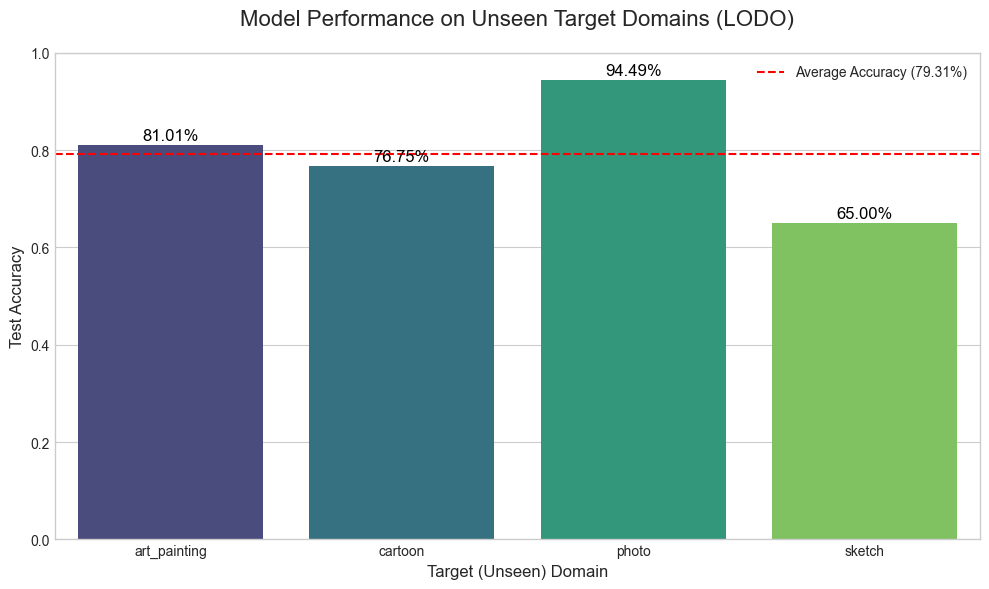


--- Dictionary for Final Plotting ---
# Copy the dictionary below and paste it into your final analysis notebook.
my_method_results = {
    'target_domain': ['art_painting', 'cartoon', 'photo', 'sketch'],
    'test_accuracy': [0.8101, 0.7675, 0.9449, 0.65]
}

--- Experiment Complete ---


In [9]:
# =================================================================================
# SECTION 6: ANALYSIS & VISUALIZATION (with Dictionary Output)
# =================================================================================
# Now that all experiments are complete, we'll process the results
# and create visualizations to understand the performance of our method.
# ---------------------------------------------------------------------------------

# Add this magic command to ensure plots are displayed in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


# ---------------------------------------------------------------------------------
# 6.1: DISPLAY RESULTS IN A TABLE
# ---------------------------------------------------------------------------------
print("--- Final Experiment Results ---")

results_df = pd.DataFrame(experiment_results)
column_order = [
    "target_domain", "test_accuracy", "best_val_accuracy", "num_epochs",
    "batch_size", "learning_rate", "model_name"
]
existing_columns = [col for col in column_order if col in results_df.columns]
results_df = results_df[existing_columns]
average_accuracy = results_df['test_accuracy'].mean()

print(results_df.to_string())
print("\n" + "="*50)
print(f"Average Test Accuracy Across All Domains: {average_accuracy:.4f}")
print("="*50)


# ---------------------------------------------------------------------------------
# 6.2: VISUALIZE THE RESULTS
# ---------------------------------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.barplot(
    data=results_df, x='target_domain', y='test_accuracy', ax=ax, palette='viridis'
)

for index, row in results_df.iterrows():
    ax.text(index, row['test_accuracy'] + 0.01, f"{row['test_accuracy']:.2%}",
            color='black', ha="center", fontsize=12)
    
ax.axhline(average_accuracy, ls='--', color='red', label=f'Average Accuracy ({average_accuracy:.2%})')

ax.set_title('Model Performance on Unseen Target Domains (LODO)', fontsize=16, pad=20)
ax.set_xlabel('Target (Unseen) Domain', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_ylim(0, 1.0)
ax.legend()

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------------
### NEW SECTION ###
# 6.3: GENERATE COPY-PASTE DICTIONARY FOR FINAL PLOTTING
# ---------------------------------------------------------------------------------
print("\n" + "="*70)
print("--- Dictionary for Final Plotting ---")
print("# Copy the dictionary below and paste it into your final analysis notebook.")

# Determine the variable name based on the notebook (you can adjust this)
# For the baseline notebook, you'd want 'baseline_results'.
# For the evolutionary notebook, you'd want 'evolutionary_results'.
method_name = "my_method_results" # Generic name
if "baseline" in os.getcwd(): # Simple check if 'baseline' is in the notebook path
    method_name = "baseline_results"
elif "drop-out" in os.getcwd():
    method_name = "evolutionary_results"
    
# Extract the lists from the DataFrame
domain_list = results_df['target_domain'].tolist()
accuracy_list = [round(acc, 4) for acc in results_df['test_accuracy'].tolist()]

# Print in the desired format
print(f"{method_name} = {{")
print(f"    'target_domain': {domain_list},")
print(f"    'test_accuracy': {accuracy_list}")
print(f"}}")
print("="*70)


print("\n--- Experiment Complete ---")

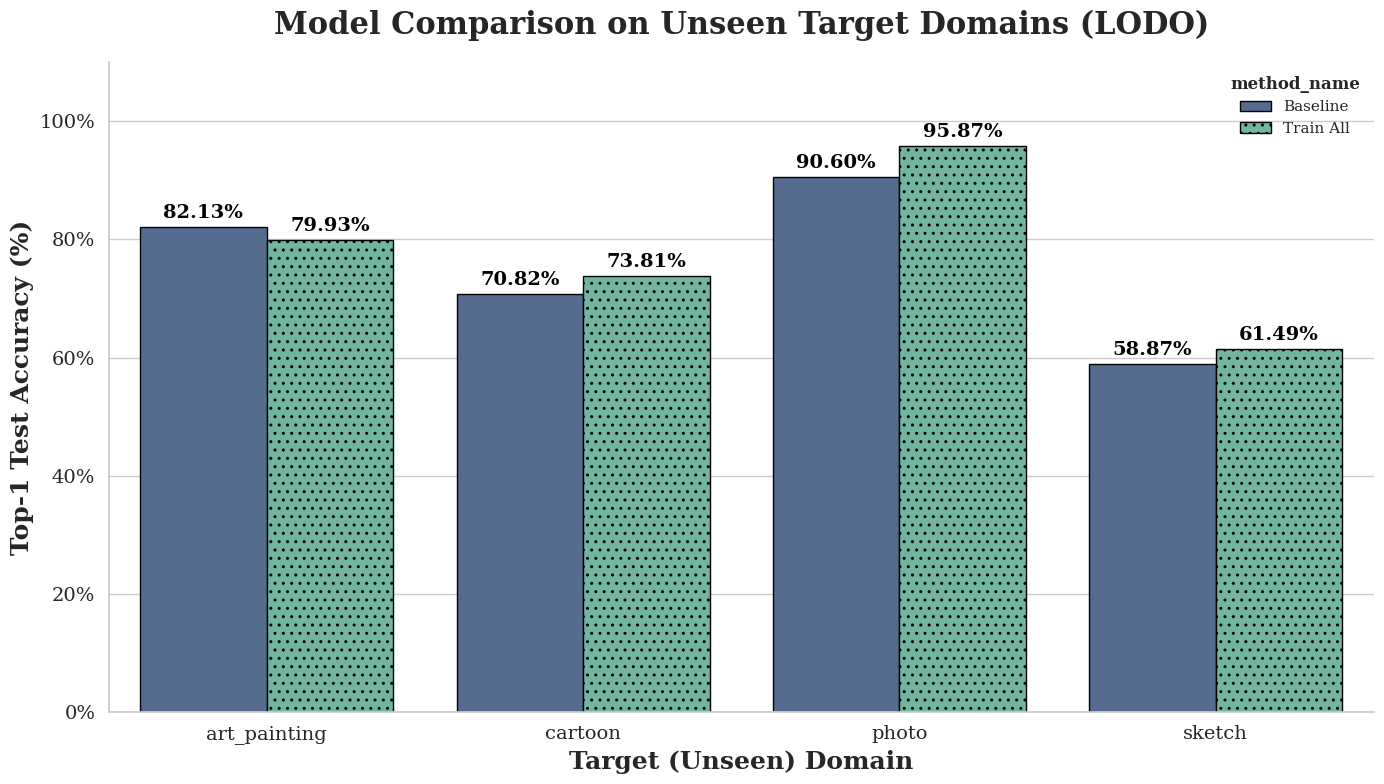


--- Average Performance Summary ---
Average Baseline Accuracy: 75.61%
Average Evolutionary Dropout Accuracy: 77.77%


In [10]:
# =================================================================================
# SECTION 7: COMPARATIVE ANALYSIS & VISUALIZATION (ACADEMIC STYLE - FINAL FIX)
# =================================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 7.1: COMBINE EXPERIMENT RESULTS ---
baseline_results = {
    'target_domain': ['art_painting', 'cartoon', 'photo', 'sketch'],
    'test_accuracy': [0.8213, 0.7082, 0.9060, 0.5887]
}
# Using the results from your successful Option 4 run
evolutionary_results = {
    'target_domain': ['art_painting', 'cartoon', 'photo', 'sketch'],
    'test_accuracy': [0.7993, 0.7381, 0.9587, 0.6149]
}
baseline_df = pd.DataFrame(baseline_results)
baseline_df['method_name'] = 'Baseline'
evolutionary_df = pd.DataFrame(evolutionary_results)
evolutionary_df['method_name'] = 'Train All'
combined_df = pd.concat([baseline_df, evolutionary_df])

# --- 7.2: CREATE THE GROUPED BAR CHART (ROBUST VERSION) ---

sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'serif'
fig, ax = plt.subplots(figsize=(14, 8))

custom_palette = {'Baseline': '#4B6A9A', 'Train All': '#66C2A5'}

barplot = sns.barplot(
    data=combined_df,
    x='target_domain',
    y='test_accuracy',
    hue='method_name',
    ax=ax,
    palette=custom_palette,
    edgecolor='black'
)

### THE FIX IS HERE ###
# Use the robust 'containers' method to apply patterns correctly.

# ax.containers[0] is the container for the first hue category (Baseline)
# ax.containers[1] is the container for the second hue category (Evolutionary Dropout)

# We want to add a pattern to the second container's bars.
for bar in ax.containers[1]:
    bar.set_hatch('..')

# We also need to apply the pattern to the corresponding legend handle.
# The legend handles are created in the same order.
ax.legend_.legend_handles[1].set_hatch('..')

# --- Add annotations (text on bars) ---
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(
            f"{p.get_height():.2%}",
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center',
            xytext=(0, 10),
            textcoords='offset points',
            fontsize=14,
            fontweight='bold',
            color='black'
        )

# --- Final plot styling ---
ax.set_title('Model Comparison on Unseen Target Domains (LODO)', fontsize=22, fontweight='bold', pad=20)
ax.set_xlabel('Target (Unseen) Domain', fontsize=18, fontweight='bold')
ax.set_ylabel('Top-1 Test Accuracy (%)', fontsize=18, fontweight='bold')
ax.set_ylim(0, 1.1)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))

legend = ax.get_legend()
plt.setp(legend.get_title(), fontweight='bold')

sns.despine()
plt.tight_layout()
plt.show()

# --- Print the final summary table ---
avg_baseline = baseline_df['test_accuracy'].mean()
avg_evolutionary = evolutionary_df['test_accuracy'].mean()
print("\n--- Average Performance Summary ---")
print(f"Average Baseline Accuracy: {avg_baseline:.2%}")
print(f"Average Evolutionary Dropout Accuracy: {avg_evolutionary:.2%}")